In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine

#### Load training and prediction window data from saved sql database

In [2]:
engine =create_engine('sqlite:///../Data/Earthquakedata.db')
df_features = pd.read_sql_table('Earthquake_features',con=engine)

In [3]:
df_features.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2025-04-14,10.916,1.80,Canada,50.695181,-118.758364,3.986182,4.942400,2.480857,1.940909,2.097333,1.758571,0
1,2025-04-15,-1.500,2.05,Canada,50.695181,-118.758364,3.950273,4.175733,2.299429,1.974545,2.047333,1.727143,0
2,2025-04-15,-0.250,0.79,Canada,50.695181,-118.758364,3.960727,4.174400,2.365143,1.941364,1.972667,1.615714,0
3,2025-04-16,-0.040,1.55,Canada,50.695181,-118.758364,3.991182,2.711733,1.205143,1.947273,1.889333,1.720000,0
4,2025-04-16,9.998,1.90,Canada,50.695181,-118.758364,3.883818,3.078267,2.666286,1.927727,1.809333,1.697143,0


In [4]:
engine =create_engine('sqlite:///../Data/Earthquakedata_predict.db')
df_predict = pd.read_sql_table('Earthquake_predict',con=engine)

In [5]:
df_predict.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2025-04-30,17.115,1.90,Canada,50.695181,-118.758364,3.679955,4.154333,2.080714,1.766818,1.886000,1.621429,NaN
1,2025-04-30,-0.710,1.12,Canada,50.695181,-118.758364,3.658136,4.122333,2.032143,1.734091,1.812667,1.491429,NaN
2,2025-04-30,65.500,2.30,Canada,50.695181,-118.758364,6.139227,8.504333,11.572143,1.756818,1.831333,1.482857,NaN
3,2025-04-30,-0.370,2.06,Canada,50.695181,-118.758364,6.190591,7.578333,11.592143,1.757273,1.828667,1.491429,NaN
4,2025-05-01,30.941,3.00,Canada,50.695181,-118.758364,7.608364,9.656400,16.113714,1.857727,1.906667,1.712857,NaN


In [6]:
list(df_features)

['date',
 'depth',
 'mag',
 'place',
 'latitude',
 'longitude',
 'depth_avg_22',
 'depth_avg_15',
 'depth_avg_7',
 'mag_avg_22',
 'mag_avg_15',
 'mag_avg_7',
 'mag_outcome']

In [7]:
# Selection of features that are needed for prediction and hence consider only them rest are just ignored for prediction purpose.

features = [f for f in list(df_features) if f not in ['date', 'mag_outcome', 'mag', 'place', 'latitude','longitude']]

# splitting traing and testing dataset with trainging size = 70% and test = 30%
X_train, X_test, y_train, y_test = train_test_split(df_features[features],
                     df_features['mag_outcome'], test_size=0.3, random_state=42)

In [8]:
features

['depth',
 'depth_avg_22',
 'depth_avg_15',
 'depth_avg_7',
 'mag_avg_22',
 'mag_avg_15',
 'mag_avg_7']

#### Training phase

* Models used are : 
    * Adaboost classifier with DecisionTree 
    * Adaboost classifier with RandomForest
    * GridSearch CV as hyper parameter tunning
    

* Model used for Deployment of application :
    * Xgboost with parameters set from above models

#### Adaboost Decision Tree Classifier

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
              "estimator__max_depth" :   [2,5,7],
              "n_estimators": [200, 400, 600]
             }

# base estimator
tree = DecisionTreeClassifier()

# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6,
ABC = AdaBoostClassifier(
    estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

#### Parameter tunning with GridSearch CV

In [10]:
# The dataset is randomly split into 5 equal parts (folds).
# 4 folds are used for training, and 1 fold is used for validation.
grid_search_ABC = GridSearchCV(ABC,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                        
                               verbose = 1)

In [11]:
grid_search_ABC.fit(X_train,y_train) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=AdaBoostClassifier(algorithm='SAMME',
                                          estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'estimator__max_depth': [2, 5, 7],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [12]:
print("Best Parameters:", grid_search_ABC.best_params_)

Best Parameters: {'estimator__max_depth': 7, 'n_estimators': 200}


In [13]:
pred_ABC=grid_search_ABC.predict(X_test)

### Evaluation Area Under curve & ROC 

ROC AUC Score: 0.9680041373381333
AUC: 0.968


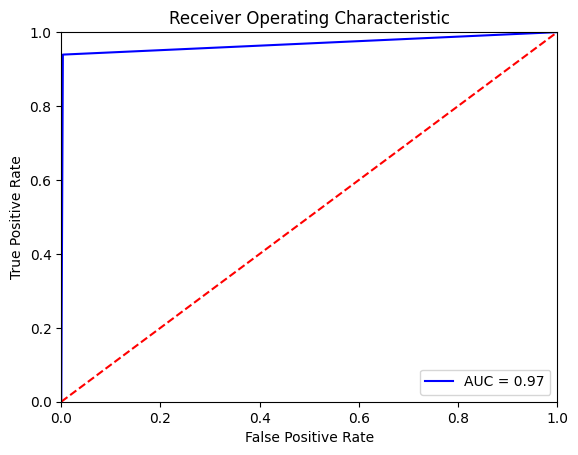

Confusion Matrix: 
 [[2507    8]
 [   9  139]]

Recall (TP/(TP+FN)) =  0.9391891891891891


In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print("ROC AUC Score:",roc_auc_score(y_test, pred_ABC))
# Alternatively
fpr, tpr, _ = roc_curve(y_test, pred_ABC)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


print("Confusion Matrix: \n",confusion_matrix(y_test,pred_ABC))
print("\nRecall (TP/(TP+FN)) = ", recall_score(y_test,pred_ABC))

In [15]:
from sklearn.metrics import accuracy_score, f1_score

# Accuracy
accuracy = accuracy_score(y_test, pred_ABC)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(y_test, pred_ABC)
print("F1 Score:", f1)

Accuracy: 0.9936162223056703
F1 Score: 0.9423728813559322


#### Adaboost Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['sqrt', 'log2']
}
# GridSearch of parameter tunning.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 700]})

In [17]:
pred=CV_rfc.predict(X_test)

### Evaluation Area Under curve & ROC 

ROC AUC Score: 0.9650233732738702
AUC: 0.965


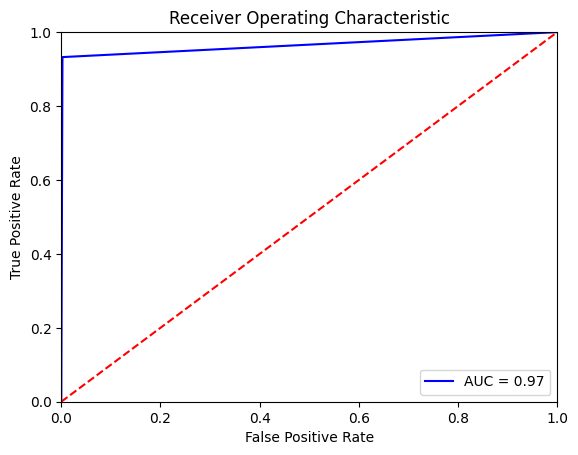

Confusion Matrix: 
 [[2509    6]
 [  10  138]]

Recall 'TP/TP+FN' =  0.9324324324324325


In [18]:

print("ROC AUC Score:", roc_auc_score(y_test, pred))
#Alternatively
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


print("Confusion Matrix: \n",confusion_matrix(y_test,pred))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,pred))

In [19]:
from sklearn.metrics import accuracy_score

# Accuracy
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(y_test, pred)
print("F1 Score:", f1)


Accuracy: 0.9939917386406308
F1 Score: 0.9452054794520548


#### XGBoost 

In [20]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)

param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'max_depth': 6,  # the maximum depth of each tree
        'eta': 0.05,  # the training step for each iteration (or eta=0.1 also we can take)
        'verbosity': 0
} 

# Train with early stopping
bst = xgb.train(
    param,
    dtrain,
    num_boost_round=5000,    # maximum rounds
    evals=[(dtest, 'eval')], # watch the test set performance
    early_stopping_rounds=10, # if 10 rounds no improvement, stop
    verbose_eval=True
)

[0]	eval-auc:0.98862
[1]	eval-auc:0.98877
[2]	eval-auc:0.98873
[3]	eval-auc:0.98878
[4]	eval-auc:0.98882
[5]	eval-auc:0.98882
[6]	eval-auc:0.98879
[7]	eval-auc:0.98879
[8]	eval-auc:0.98892
[9]	eval-auc:0.98891
[10]	eval-auc:0.99202
[11]	eval-auc:0.99207
[12]	eval-auc:0.99211
[13]	eval-auc:0.99216
[14]	eval-auc:0.99215
[15]	eval-auc:0.99215
[16]	eval-auc:0.99217
[17]	eval-auc:0.99220
[18]	eval-auc:0.99222
[19]	eval-auc:0.99203
[20]	eval-auc:0.99203
[21]	eval-auc:0.99202
[22]	eval-auc:0.99188
[23]	eval-auc:0.99188
[24]	eval-auc:0.99191
[25]	eval-auc:0.99195
[26]	eval-auc:0.99195
[27]	eval-auc:0.99498
[28]	eval-auc:0.99502
[29]	eval-auc:0.99501
[30]	eval-auc:0.99502
[31]	eval-auc:0.99502
[32]	eval-auc:0.99503
[33]	eval-auc:0.99503
[34]	eval-auc:0.99519
[35]	eval-auc:0.99518
[36]	eval-auc:0.99524
[37]	eval-auc:0.99525
[38]	eval-auc:0.99525
[39]	eval-auc:0.99522
[40]	eval-auc:0.99527
[41]	eval-auc:0.99525
[42]	eval-auc:0.99525
[43]	eval-auc:0.99525
[44]	eval-auc:0.99526
[45]	eval-auc:0.9952

In [21]:
# Predict with best_iteration
pred_probs = bst.predict(dtest, iteration_range=(0, bst.best_iteration))

ROC AUC Score: 0.9952219117726075
AUC: 0.9952


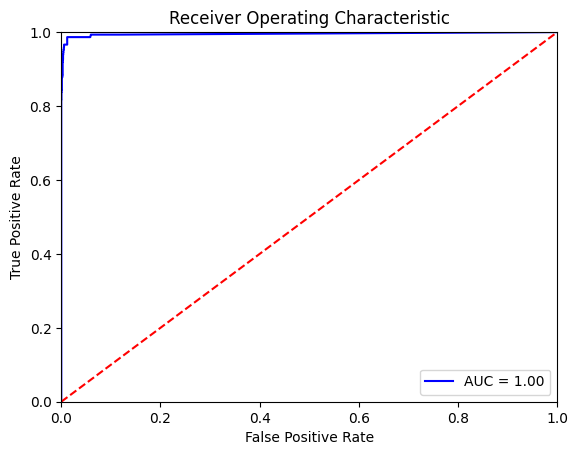

Confusion Matrix: 
 [[2502   13]
 [   7  141]]

Recall 'TP/TP+FN' =  0.9527027027027027


In [22]:
print ("ROC AUC Score:", roc_auc_score(y_test, pred_probs))
# Alternatively
fpr, tpr, _ = roc_curve(y_test, pred_probs)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

# Thresholding (default 0.5)
pred_labels = (pred_probs > 0.3).astype(int)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("Confusion Matrix: \n",confusion_matrix(y_test,pred_labels))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,pred_labels))

In [23]:
from sklearn.metrics import accuracy_score

# Accuracy
accuracy = accuracy_score(y_test, pred_labels)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(y_test, pred_labels)
print("F1 Score:", f1)

Accuracy: 0.9924896733007886
F1 Score: 0.9337748344370861


In [24]:
print(f"Predicted positives: {np.sum(pred_labels)}")
print(f"Actual positives: {np.sum(y_test)}")

Predicted positives: 154
Actual positives: 148


In [25]:
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
best_thresh = 0.5
best_f1 = 0

for thresh in thresholds:
    preds_thresh = (pred_probs > thresh).astype(int)
    score = f1_score(y_test, preds_thresh)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print(f"Best Threshold = {best_thresh} with F1 = {best_f1:.4f}")

# Now use this best threshold
pred_labels = (pred_probs > best_thresh).astype(int)


Best Threshold = 0.25000000000000006 with F1 = 0.9377


### Final thoughts on which model to consider on application:
We can see above that xgboost algorithm has higher auc score than adaboost decision tree and random forest, as it is evident from the ROC curve. Hence we consider xgboost for prediction of live data

#### Preparing prediction and plot for live unknown data we got in `df_predict` with `mag_outcome = Nan`

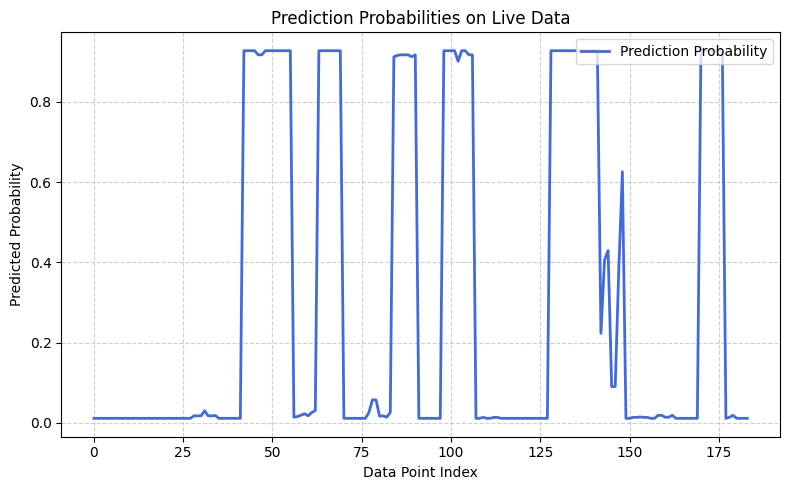

In [26]:
import matplotlib.pyplot as plt

# Create DMatrix without labels (live unknown data)
dlive = xgb.DMatrix(df_predict[features])

# Predict probabilities
pred_probs = bst.predict(dlive)

# Plotting nicely
plt.figure(figsize=(8, 5))  # Make the figure wider
plt.plot(pred_probs, color='royalblue', linewidth=2, label='Prediction Probability')

plt.title('Prediction Probabilities on Live Data', fontsize=12)
plt.xlabel('Data Point Index', fontsize=10)
plt.ylabel('Predicted Probability', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()


### Prediction 

* Select specific features such as `data`,`place`,`long`,`lat` and give earthquake probablity from prediction at that place and date as `quake` probability
* with taking only 7 days rolling period data from predict dataframe since this outcome value is NaN and we need to predict next 7 days period.

In [27]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']].copy() 
live_set['quake'] = pred_probs 

# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date'] = pd.to_datetime(live_set['date'], format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7, unit='d')

live_set.tail()

,date,place,latitude,longitude,quake
68,2025-05-09,Puerto Rico,18.243237,-66.790990,0.366714
69,2025-05-09,Texas,31.721023,-102.720109,0.016243
70,2025-05-09,U.S. Virgin Islands,18.847328,-64.746338,0.917383
71,2025-05-09,Utah,39.490944,-112.022536,0.011552
72,2025-05-09,Washington,47.354425,-121.346455,0.011552


In [28]:
import datetime as dt
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.today().strftime('%Y-%m-%d')]))
days.sort()

print(days)

# Check if days has enough elements before accessing
if len(days) > 2:
    predict_day = days[2]
else:
    predict_day = None  # or handle it appropriately
    print("Not enough future days available for prediction.")

print(predict_day)

['2025-05-03', '2025-05-04', '2025-05-05', '2025-05-06', '2025-05-07', '2025-05-08', '2025-05-09']
2025-05-05


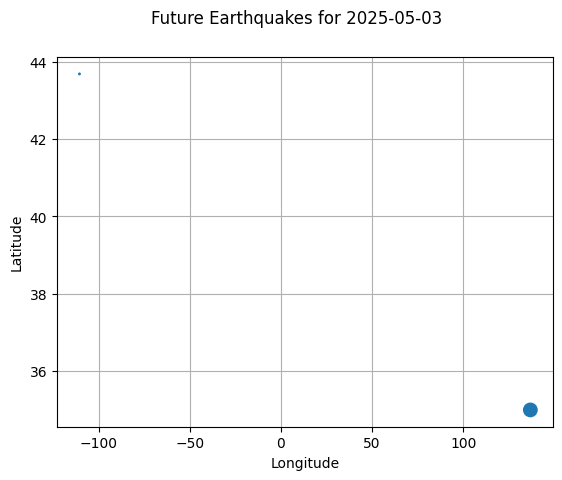

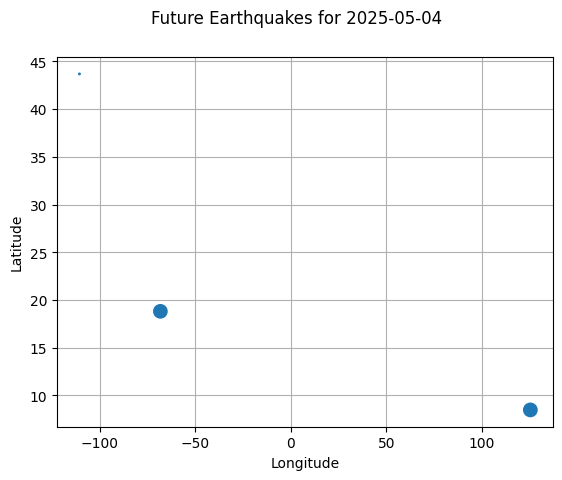

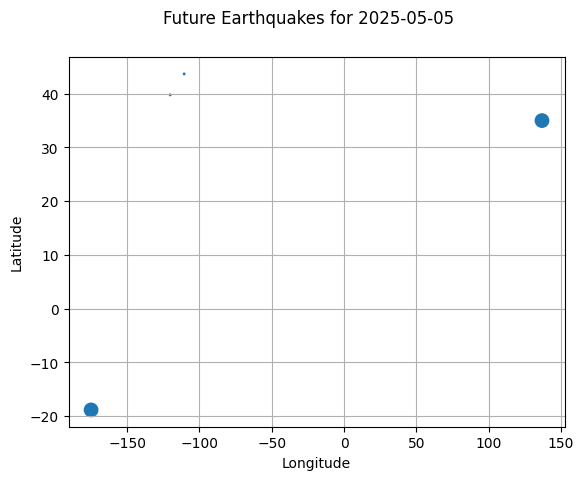

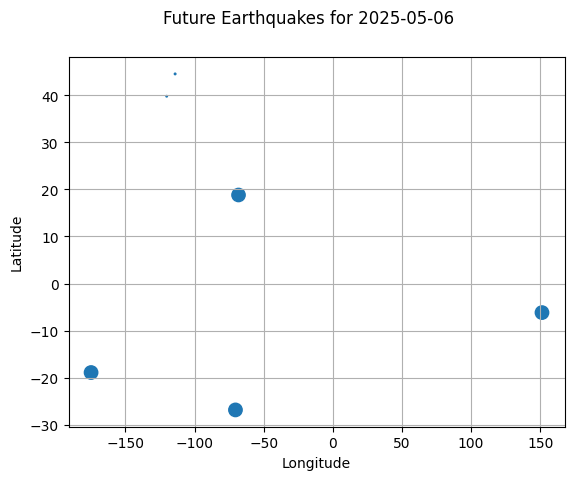

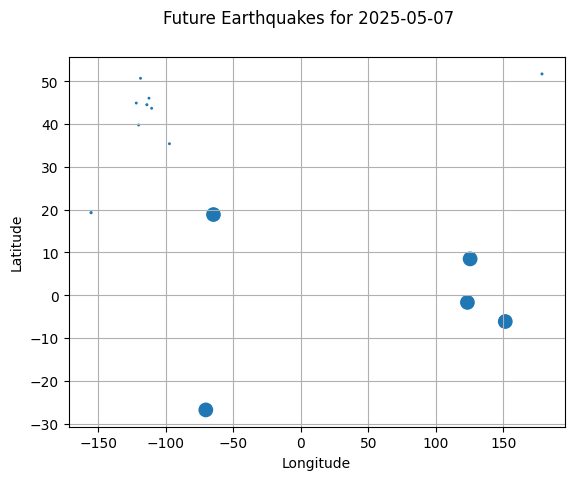

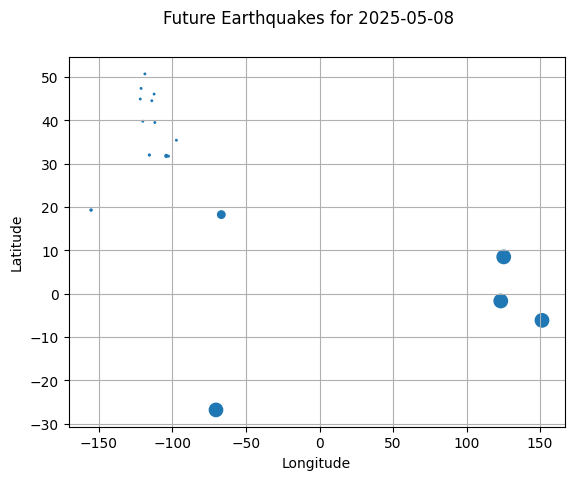

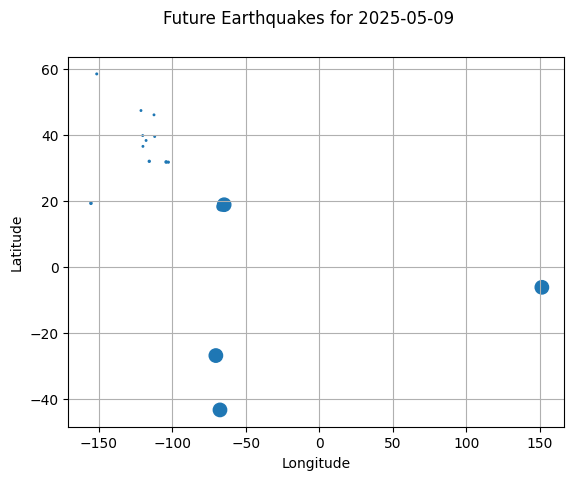

In [29]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()